In [1]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf          

## Colocar la direccion de la carpeta de iamgenes originales
path_o= '/home/fer/MATLAB_1/DenoisingNetwork/train/original'
path_n= '/home/fer/MATLAB_1/DenoisingNetwork/train/noisy'
path_r = '/home/fer/MATLAB_1/DenoisingNetwork/restauradas/'

def main():                                                                                                             
    print('Hola Luis Fernando')                                                                                         
                                                                                                                        
def data(path):
    training_data = []
    index = os.listdir(path)
    index.sort()
    index =index[0:1]
    for img in index:
        pic_o = cv2.imread(os.path.join(path,img),0)
        pic_o = cv2.resize(pic_o,(688,688))
        training_data.append([pic_o])
    training = np.array(training_data).reshape(len(training_data),pic_o.shape[0],pic_o.shape[1])
    return training
                                                                                                                      
def show_figure(x_test):  
    ## Generar una figura vacia
    fig, axs = plt.subplots(1, 5)                                                                                                                                                                              
    plt.gray()                                                                                                          
    a=0                                                                                                                 
                                                                                                 
    for j in range(5):    
        ## Graficar en cada posicon del subplot
        axs[j].imshow(tf.squeeze(x_test[a]))                                                                                                                                              
        a = a+1  
            
def show_one(x_test,i):
    ## Funcion para verificar solo una Imagen
    fig, axs = plt.subplots(1, 1)  
    fig.tight_layout(pad=-1)                                                                                            
    plt.gray()  
    axs.imshow(tf.squeeze(x_test[i]))  
    

def normalization(train, test):
    ## Normalizacion de los valores se colocan entre 0-1
    train_n = train.astype('float32')/255
    test_n = test.astype('float32')/255
    train_n = train_n[...,tf.newaxis]
    test_n = test_n[...,tf.newaxis]
    return train_n, test_n


def noisy(train, test, noisy_factor=0.1):
    ## Aumentor ruido artificial a las imagenes
    x_train_noisy = train + noisy_factor*tf.random.normal(shape = train.shape)
    x_test_noisy = test + noisy_factor*tf.random.normal(shape = test.shape)
    
    x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.) 
    x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)
    return x_train_noisy, x_test_noisy

def plot_noisy(original, noisy):
    plt.figure(figsize=(20,8))
    plt.gray()
    n =original.shape[0]
    for i in range(n):
        ax = plt.subplot(2, n , i+1)
        plt.title("Original",size=20)
        plt.imshow(tf.squeeze(original[i]))
        plt.gray()
        bx = plt.subplot(2, n, n+ i +1) 
        plt.title("original + noise", size=20) 
        plt.imshow(tf.squeeze(noisy[i])) 
    plt.show()

In [2]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Input

class NoiseReducer(tf.keras.Model): 
  def __init__(self):

    super(NoiseReducer, self).__init__() 

    self.encoder = tf.keras.Sequential([ 
        Input(shape=(688, 688, 1)), 
    Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
    Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
    Conv2D(16, (3,3), activation='relu', padding='same', strides=2)]) 
    
    self.decoder = tf.keras.Sequential([ 
        Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
        Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
        Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
        Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')]) 
  
  def call(self, x): 
    encoded = self.encoder(x) 
    decoded = self.decoder(encoded) 
    return decoded

In [3]:
## Obtener las imagenesde las dirreciones establecidas
x_train = data(path_o)
x_test = data(path_o)

x_train_noisy = data(path_n)
x_test_noisy = data(path_n)

x_train.shape[0]

1

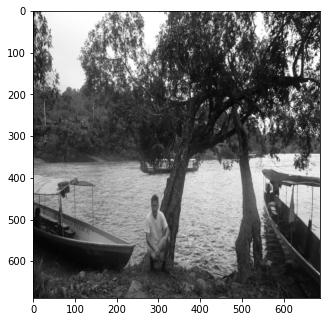

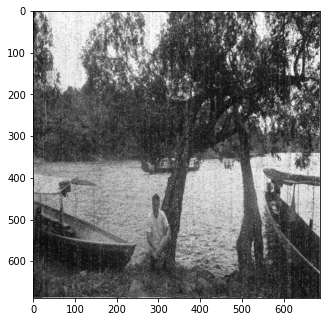

In [4]:
## Monstrar si las imagenes son las correctas
show_one(x_train,0)
show_one(x_train_noisy,0)

In [5]:
## Normalizar los datos en como maximo 1
x_train_n, x_test_n =normalization(x_train, x_test)
x_train_noisy, x_test_noisy = normalization(x_train_noisy, x_test_noisy)
x_train_noisy.shape

(1, 688, 688, 1)

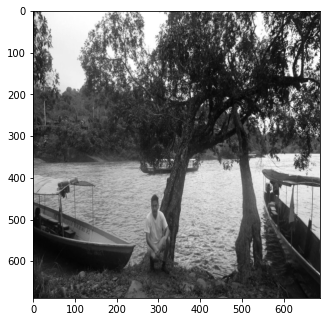

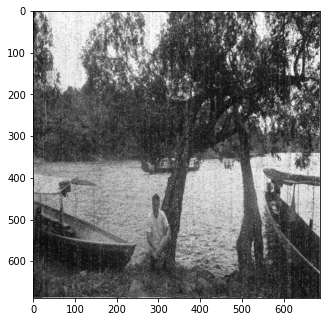

In [6]:
show_one(x_train_n, 0)
show_one(x_train_noisy, 0)

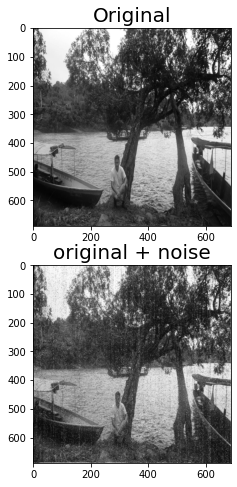

In [7]:
plot_noisy(x_train_n,x_train_noisy)

In [8]:
## Generacion de la clase de la red neuronal
autoencoder = NoiseReducer()

In [9]:
autoencoder.compile(optimizer='adam', loss='mse')

In [10]:
autoencoder.fit(x_train_noisy, 
                x_train_n, 
                epochs=600, 
                shuffle=True, 
                validation_data=(x_test_noisy, x_test_n))

Epoch 1/600
1/1 [==============================] - 3s 3s/step - loss: 0.0855 - val_loss: 0.0852
Epoch 2/600
1/1 [==============================] - 2s 2s/step - loss: 0.0852 - val_loss: 0.0850
Epoch 3/600
1/1 [==============================] - 2s 2s/step - loss: 0.0850 - val_loss: 0.0846
Epoch 4/600
1/1 [==============================] - 2s 2s/step - loss: 0.0846 - val_loss: 0.0842
Epoch 5/600
1/1 [==============================] - 2s 2s/step - loss: 0.0842 - val_loss: 0.0838
Epoch 6/600
1/1 [==============================] - 2s 2s/step - loss: 0.0838 - val_loss: 0.0833
Epoch 7/600
1/1 [==============================] - 2s 2s/step - loss: 0.0833 - val_loss: 0.0826
Epoch 8/600
1/1 [==============================] - 2s 2s/step - loss: 0.0826 - val_loss: 0.0818
Epoch 9/600
1/1 [==============================] - 2s 2s/step - loss: 0.0818 - val_loss: 0.0808
Epoch 10/600
1/1 [==============================] - 2s 2s/step - loss: 0.0808 - val_loss: 0.0796
Epoch 11/600
1/1 [=====================

1/1 [==============================] - 2s 2s/step - loss: 0.0090 - val_loss: 0.0089
Epoch 86/600
1/1 [==============================] - 2s 2s/step - loss: 0.0089 - val_loss: 0.0088
Epoch 87/600
1/1 [==============================] - 2s 2s/step - loss: 0.0088 - val_loss: 0.0088
Epoch 88/600
1/1 [==============================] - 2s 2s/step - loss: 0.0088 - val_loss: 0.0087
Epoch 89/600
1/1 [==============================] - 2s 2s/step - loss: 0.0087 - val_loss: 0.0086
Epoch 90/600
1/1 [==============================] - 2s 2s/step - loss: 0.0086 - val_loss: 0.0086
Epoch 91/600
1/1 [==============================] - 2s 2s/step - loss: 0.0086 - val_loss: 0.0085
Epoch 92/600
1/1 [==============================] - 2s 2s/step - loss: 0.0085 - val_loss: 0.0085
Epoch 93/600
1/1 [==============================] - 2s 2s/step - loss: 0.0085 - val_loss: 0.0085
Epoch 94/600
1/1 [==============================] - 2s 2s/step - loss: 0.0085 - val_loss: 0.0084
Epoch 95/600
1/1 [=========================

Epoch 169/600
1/1 [==============================] - 2s 2s/step - loss: 0.0071 - val_loss: 0.0071
Epoch 170/600
1/1 [==============================] - 2s 2s/step - loss: 0.0071 - val_loss: 0.0071
Epoch 171/600
1/1 [==============================] - 2s 2s/step - loss: 0.0071 - val_loss: 0.0071
Epoch 172/600
1/1 [==============================] - 2s 2s/step - loss: 0.0071 - val_loss: 0.0071
Epoch 173/600
1/1 [==============================] - 3s 3s/step - loss: 0.0071 - val_loss: 0.0071
Epoch 174/600
1/1 [==============================] - 3s 3s/step - loss: 0.0071 - val_loss: 0.0070
Epoch 175/600
1/1 [==============================] - 3s 3s/step - loss: 0.0070 - val_loss: 0.0070
Epoch 176/600
1/1 [==============================] - 2s 2s/step - loss: 0.0070 - val_loss: 0.0070
Epoch 177/600
1/1 [==============================] - 2s 2s/step - loss: 0.0070 - val_loss: 0.0070
Epoch 178/600
1/1 [==============================] - 2s 2s/step - loss: 0.0070 - val_loss: 0.0070
Epoch 179/600
1/1 [=

1/1 [==============================] - 2s 2s/step - loss: 0.0063 - val_loss: 0.0064
Epoch 253/600
1/1 [==============================] - 2s 2s/step - loss: 0.0064 - val_loss: 0.0064
Epoch 254/600
1/1 [==============================] - 2s 2s/step - loss: 0.0064 - val_loss: 0.0064
Epoch 255/600
1/1 [==============================] - 2s 2s/step - loss: 0.0064 - val_loss: 0.0064
Epoch 256/600
1/1 [==============================] - 2s 2s/step - loss: 0.0064 - val_loss: 0.0064
Epoch 257/600
1/1 [==============================] - 3s 3s/step - loss: 0.0064 - val_loss: 0.0064
Epoch 258/600
1/1 [==============================] - 2s 2s/step - loss: 0.0064 - val_loss: 0.0064
Epoch 259/600
1/1 [==============================] - 2s 2s/step - loss: 0.0064 - val_loss: 0.0063
Epoch 260/600
1/1 [==============================] - 2s 2s/step - loss: 0.0063 - val_loss: 0.0063
Epoch 261/600
1/1 [==============================] - 3s 3s/step - loss: 0.0063 - val_loss: 0.0062
Epoch 262/600
1/1 [===============

1/1 [==============================] - 2s 2s/step - loss: 0.0058 - val_loss: 0.0058
Epoch 336/600
1/1 [==============================] - 2s 2s/step - loss: 0.0058 - val_loss: 0.0057
Epoch 337/600
1/1 [==============================] - 2s 2s/step - loss: 0.0057 - val_loss: 0.0057
Epoch 338/600
1/1 [==============================] - 2s 2s/step - loss: 0.0057 - val_loss: 0.0058
Epoch 339/600
1/1 [==============================] - 2s 2s/step - loss: 0.0058 - val_loss: 0.0058
Epoch 340/600
1/1 [==============================] - 2s 2s/step - loss: 0.0058 - val_loss: 0.0057
Epoch 341/600
1/1 [==============================] - 2s 2s/step - loss: 0.0057 - val_loss: 0.0057
Epoch 342/600
1/1 [==============================] - 2s 2s/step - loss: 0.0057 - val_loss: 0.0057
Epoch 343/600
1/1 [==============================] - 2s 2s/step - loss: 0.0057 - val_loss: 0.0057
Epoch 344/600
1/1 [==============================] - 2s 2s/step - loss: 0.0057 - val_loss: 0.0057
Epoch 345/600
1/1 [===============

1/1 [==============================] - 2s 2s/step - loss: 0.0054 - val_loss: 0.0054
Epoch 419/600
1/1 [==============================] - 2s 2s/step - loss: 0.0054 - val_loss: 0.0054
Epoch 420/600
1/1 [==============================] - 2s 2s/step - loss: 0.0054 - val_loss: 0.0054
Epoch 421/600
1/1 [==============================] - 2s 2s/step - loss: 0.0054 - val_loss: 0.0054
Epoch 422/600
1/1 [==============================] - 2s 2s/step - loss: 0.0054 - val_loss: 0.0054
Epoch 423/600
1/1 [==============================] - 2s 2s/step - loss: 0.0054 - val_loss: 0.0053
Epoch 424/600
1/1 [==============================] - 2s 2s/step - loss: 0.0053 - val_loss: 0.0053
Epoch 425/600
1/1 [==============================] - 2s 2s/step - loss: 0.0053 - val_loss: 0.0053
Epoch 426/600
1/1 [==============================] - 2s 2s/step - loss: 0.0053 - val_loss: 0.0053
Epoch 427/600
1/1 [==============================] - 2s 2s/step - loss: 0.0053 - val_loss: 0.0053
Epoch 428/600
1/1 [===============

1/1 [==============================] - 2s 2s/step - loss: 0.0051 - val_loss: 0.0051
Epoch 502/600
1/1 [==============================] - 2s 2s/step - loss: 0.0051 - val_loss: 0.0051
Epoch 503/600
1/1 [==============================] - 3s 3s/step - loss: 0.0051 - val_loss: 0.0050
Epoch 504/600
1/1 [==============================] - 2s 2s/step - loss: 0.0050 - val_loss: 0.0050
Epoch 505/600
1/1 [==============================] - 3s 3s/step - loss: 0.0050 - val_loss: 0.0050
Epoch 506/600
1/1 [==============================] - 2s 2s/step - loss: 0.0050 - val_loss: 0.0050
Epoch 507/600
1/1 [==============================] - 2s 2s/step - loss: 0.0050 - val_loss: 0.0050
Epoch 508/600
1/1 [==============================] - 3s 3s/step - loss: 0.0050 - val_loss: 0.0050
Epoch 509/600
1/1 [==============================] - 3s 3s/step - loss: 0.0050 - val_loss: 0.0050
Epoch 510/600
1/1 [==============================] - 3s 3s/step - loss: 0.0050 - val_loss: 0.0050
Epoch 511/600
1/1 [===============

1/1 [==============================] - 2s 2s/step - loss: 0.0049 - val_loss: 0.0048
Epoch 585/600
1/1 [==============================] - 2s 2s/step - loss: 0.0048 - val_loss: 0.0048
Epoch 586/600
1/1 [==============================] - 2s 2s/step - loss: 0.0048 - val_loss: 0.0048
Epoch 587/600
1/1 [==============================] - 2s 2s/step - loss: 0.0048 - val_loss: 0.0048
Epoch 588/600
1/1 [==============================] - 3s 3s/step - loss: 0.0048 - val_loss: 0.0048
Epoch 589/600
1/1 [==============================] - 3s 3s/step - loss: 0.0048 - val_loss: 0.0048
Epoch 590/600
1/1 [==============================] - 2s 2s/step - loss: 0.0048 - val_loss: 0.0048
Epoch 591/600
1/1 [==============================] - 2s 2s/step - loss: 0.0048 - val_loss: 0.0048
Epoch 592/600
1/1 [==============================] - 2s 2s/step - loss: 0.0048 - val_loss: 0.0048
Epoch 593/600
1/1 [==============================] - 2s 2s/step - loss: 0.0048 - val_loss: 0.0047
Epoch 594/600
1/1 [===============

In [11]:
encoded_imgs=autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs=autoencoder.decoder(encoded_imgs)
decoded_imgs.shape

TensorShape([1, 688, 688, 1])

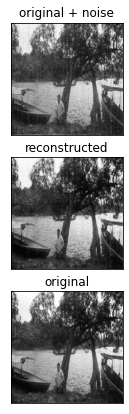

In [12]:

n = 1
plt.figure(figsize=(20, 7))
plt.gray()
for i in range(n): 
  # display original + noise 
    bx = plt.subplot(3, n, i + 1) 
    plt.title("original + noise") 
    plt.imshow(tf.squeeze(x_test_noisy[i])) 
    bx.get_xaxis().set_visible(False) 
    bx.get_yaxis().set_visible(False) 

    # display reconstruction 
    cx = plt.subplot(3, n, i + n + 1) 
    plt.title("reconstructed") 
    plt.imshow(tf.squeeze(decoded_imgs[i])) 
    cx.get_xaxis().set_visible(False) 
    cx.get_yaxis().set_visible(False) 

    # display original 
    ax = plt.subplot(3, n, i + 2*n + 1) 
    plt.title("original") 
    plt.imshow(tf.squeeze(x_test[i])) 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 

plt.show()

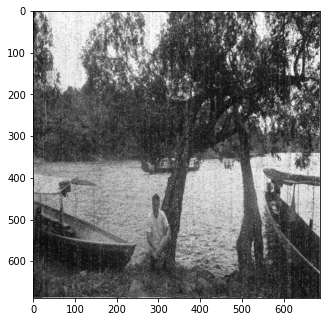

In [13]:
show_one(x_train_noisy,0)

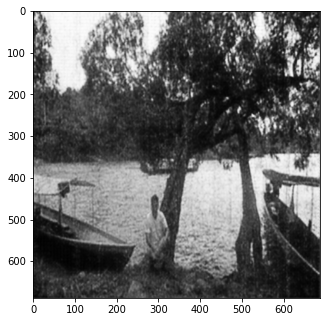

In [14]:
show_one(decoded_imgs,0)

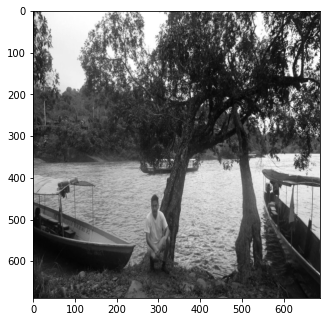

In [15]:
show_one(x_test_n,0)

In [21]:
## convertir de tensor a una numpy
restauracion = decoded_imgs.numpy()

## regresar a escala de 0 255
norm_image = cv2.normalize(restauracion, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

## convertir al tipo de dato inicial
norm_image = norm_image.astype(np.uint8)


In [22]:
cv2.imwrite(os.path.join(path_r , '1.jpg'), norm_image[0,:,:,0])

True

In [18]:
2**7

128

In [19]:
128*128

16384

In [20]:
64+16

80